In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np


class RayTracer(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        
    def forward(self, x):
        return x


In [2]:
def diff(p, dim):
    if dim==0:
        p_xdiff = p[1:,:,:] - p[:-1,:,:]
        return torch.cat((p_xdiff, p_xdiff[-2:-1,:,:]))
    elif dim==1:
        p_ydiff = p[:,1:,:] - p[:,:-1,:]
        return torch.cat((p_ydiff, p_ydiff[:,-2:-1,:]), dim=1)
    else:
        raise ValueError('Diff dimension should by either 0 or 1.')



def interpolate2d(coords, values, targets):
    Nx, Ny, Ndim = coords.shape
    Mx, My, Mdim = targets.shape
    
    # Reshape input coordinates & values, and truncate edges
    A  = coords[:-1, :-1, :].view(1, 1, Nx-1, Ny-1, Ndim)
    B  = coords[ 1:, :-1, :].view(1, 1, Nx-1, Ny-1, Ndim)
    C  = coords[:-1,  1:, :].view(1, 1, Nx-1, Ny-1, Ndim)
    D  = coords[ 1:,  1:, :].view(1, 1, Nx-1, Ny-1, Ndim)
    
    VA = values[:-1, :-1   ].view(1, 1, Nx-1, Ny-1)
    VB = values[ 1:, :-1   ].view(1, 1, Nx-1, Ny-1)
    VC = values[:-1,  1:   ].view(1, 1, Nx-1, Ny-1)
    VD = values[ 1:,  1:   ].view(1, 1, Nx-1, Ny-1)

    
    # Reshape target coordinates
    Tx = targets[:,:,0].view(Mx, My, 1, 1)
    Ty = targets[:,:,1].view(Mx, My, 1, 1)
    
    # Compute difference vectors
    AB = B - A
    AC = C - A
    DB = B - D
    DC = C - D
    
    # Seperate x- and y-variables for brevity
    Ax  =  A[:, :, :, :, 0]
    Ay  =  A[:, :, :, :, 1]
    Dx  =  D[:, :, :, :, 0]
    Dy  =  D[:, :, :, :, 1]
    
    ABx =  AB[:, :, :, :, 0]
    ABy =  AB[:, :, :, :, 1]
    ACx =  AC[:, :, :, :, 0]
    ACy =  AC[:, :, :, :, 1]
    DBx =  DB[:, :, :, :, 0]
    DBy =  DB[:, :, :, :, 1]
    DCx =  DC[:, :, :, :, 0]
    DCy =  DC[:, :, :, :, 1]

    
    # Compute coefficients
    denom_A = ABx*ACy - ABy*ACx
    b_A = ((Tx - Ax)*ACy + (Ay-Ty)*ACx) / denom_A
    c_A = ((Ax - Tx)*ABy  + (Ty-Ay)*ABx)  / denom_A
    
    denom_D = DBx*DCy - DBy*DCx
    b_D = ((Tx - Dx)*DCy + (Dy-Ty)*DCx) / denom_D
    c_D = ((Dx - Tx)*DBy  + (Ty-Dy)*DBx)  / denom_D
    
    # Mask coefficients to limit to corresponding triangles
    # Note: Each triangle ABC or DBC only corresponds with a small number of
    # target samples that lie inside that triangle. The rest of the target
    # samples is ignored by that trianlge through masking. Furthermore,
    # in order to correctly count the edges, the masks for A and D are slightly
    # different: A uses ≥ & ≤, while D uses > & <.)
    mask_A = torch.logical_and(torch.logical_and(b_A>=0, c_A>=0), b_A+c_A<=1)
    mask_D = torch.logical_and(torch.logical_and(b_D>0, c_D>0), b_D+c_D<1)
    
    # Compute interpolated values
    interp_values = torch.sum(mask_A * (VA + (VB-VA)*b_A + (VC-VA)*c_A), (2,3))\
                  + torch.sum(mask_D * (VD + (VB-VD)*b_D + (VC-VD)*c_D), (2,3))
    
    return interp_values

# Point source
Nx = 20
Ny = 20

p0 = torch.tensor((0,0,0)).view(1,1,3)
p1x, p1y = torch.meshgrid(torch.linspace(-1.1,1,Nx), torch.linspace(-1,1,Ny))
p1z = torch.linspace(0.8,1.2,Nx)*torch.ones(Ny,Nx)
p1 = torch.stack((p1x, p1y, p1z), 2)

s0 = p1 - p0

# CCD plane
screenpoint = torch.tensor((0,0,2)).view(1,1,3)
screennorm  = torch.tensor((0,0,-1)).view(1,1,3)

# Compute ray intersections with screen
d = torch.sum((screenpoint - p0)*(screennorm), dim=2, keepdim=True) / torch.sum(s0*screennorm, dim=2, keepdim=True)
pscreen = p0 + p1*d

### Compute screen coordinates

# Approximate ray density by computing cross product
p1_xdiff = diff(p1, 0)
p1_ydiff = diff(p1, 1)
p1_areas = p1_xdiff.cross(p1_ydiff).norm(dim=2)

pscreen_xdiff = diff(pscreen, 0)
pscreen_ydiff = diff(pscreen, 1)
pscreen_areas = pscreen_xdiff.cross(pscreen_ydiff).norm(dim=2)

s_norm = s0.norm(dim=2)
intensities = (1 / (s_norm*s_norm)) * (p1_areas / pscreen_areas)

# Interpolated resampling to image
### Assume screen normal=-z for now
coords = pscreen[:,:,0:2]
Nx_screen = 50
Ny_screen = 50
targets = torch.stack(torch.meshgrid(\
        torch.linspace(-2,2,Nx_screen),\
        torch.linspace(-2,2,Ny_screen)), 2)

interp_intensities = interpolate2d(coords, intensities, targets)

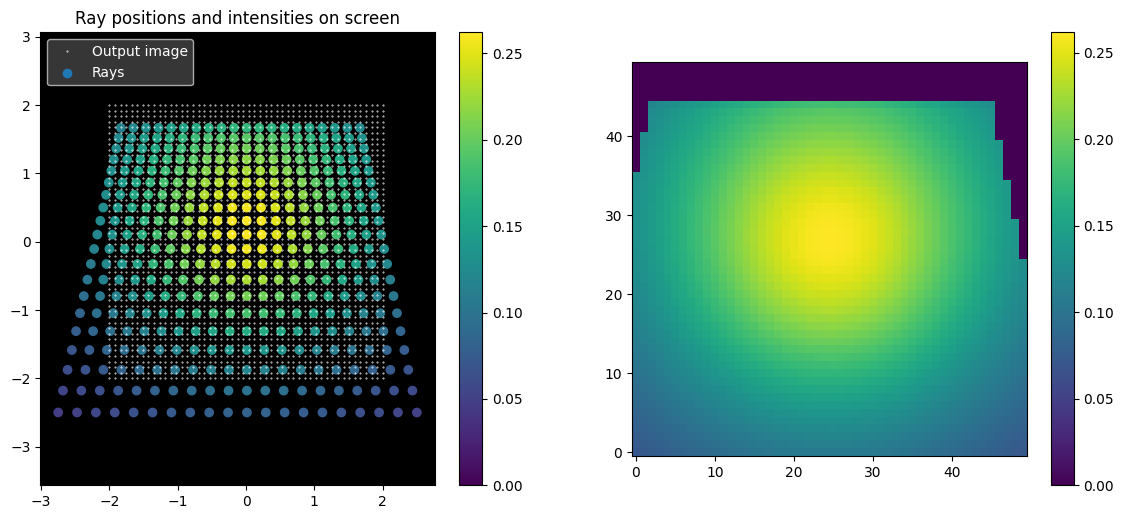

In [3]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
fig.dpi = 100
xc = pscreen.view(Nx*Ny, 3)[:, 0]
yc = pscreen.view(Nx*Ny, 3)[:, 1]
xt = targets.view(Nx_screen*Ny_screen, 2)[:, 0]
yt = targets.view(Nx_screen*Ny_screen, 2)[:, 1]
scat = ax1.scatter(xc, yc, s=None, c=intensities, label='Rays', vmin=0)
plt.colorbar(scat, ax=ax1)
ax1.plot(xt, yt, '.w', markersize=0.8, label='Output image')
ax1.axis('equal')
ax1.set_facecolor('black')
legend = ax1.legend(loc=2, facecolor='#444444')
for text in legend.get_texts():
    text.set_color("white")
ax1.set_title('Ray positions and intensities on screen')

plt.imshow(interp_intensities.T)
plt.gca().invert_yaxis()
plt.colorbar(ax=ax2)

plt.show()